In [64]:
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
### Detrend the data
#### Seasonality (Monthly / Semi-monthly circle (Wage related))

### Adding features
#### Add daily oil price into training features (fillna [2013-1-1] with the bfill method); daily oil price has negative correlation with most of products 
#### Add earthquake effect into training features.
#### Holiday-related features (holiday_events: 0/1)
### Prediction
#### Create models for each store or each cluster of stores? (54 stores, 17 clusters)
#### Use the hybrid model. LinearRegressor or LogisticRegressor for trend prediction, RF or GBR for residual prediction.


In [309]:
holiday_events=pd.read_csv('holidays_events.csv',parse_dates=['date'])
oil=pd.read_csv('oil.csv',parse_dates=['date'])
stores=pd.read_csv('stores.csv')
train=pd.read_csv('train.csv',parse_dates=['date'])
test=pd.read_csv('test.csv')
transactions=pd.read_csv('transactions.csv')

## Correlation between oil price and sales of various products

Text(0, 0.5, 'Correlation with daily oil price')

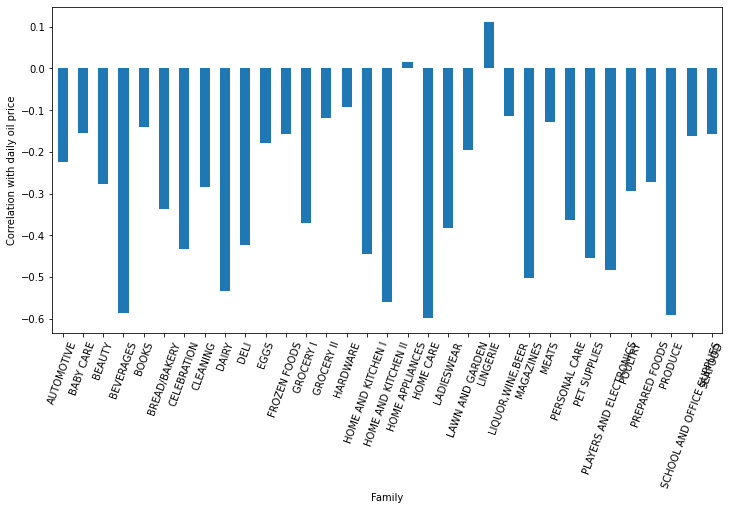

In [418]:
oil_corr=pd.DataFrame(columns=sorted(train['store_nbr'].unique()),index = train['family'].unique())

for i in train['store_nbr'].unique():
    df=train[train['store_nbr']==i].pivot('date','family','sales').merge(oil.set_index('date'),
                                                                         on='date')
    oil_corr[i]=df.corr()['dcoilwtico'][:-1]

f,ax=plt.subplots(figsize=(12,6))
oil_corr.mean(axis=1).plot(kind='bar',ax=ax,rot=70) # Average over all the stores
ax.set_xlabel('Family')
ax.set_ylabel('Correlation with daily oil price')

<AxesSubplot:xlabel='date'>

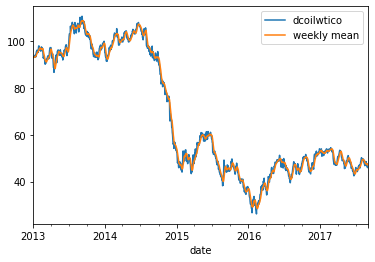

In [413]:
# Not only the daily price, but also the price over the past week should be considered
oil.fillna(method='bfill',inplace=True) # fill nan value with backfill method 
oil['weekly mean']=oil['dcoilwtico'].rolling(7,min_periods=1).mean() # compute the 7-day averaged oil price
oil.plot(x='date',y=['dcoilwtico','weekly mean'])

## Holiday-related features (holiday_events: 0/1)

In [414]:
## Merge the oil information to training dataset
train=train.merge(oil,on='date',how='left')

In [343]:
print(holiday_events['locale'].value_counts())
## We count 'Holiday' with transferred == 'False','Event','Additional','Transfer','Bridge','Work Day'
## as true holidays
holiday_events_new=holiday_events[holiday_events['transferred']==False]
## Find national holidays 
National_holiday = holiday_events_new[holiday_events_new['locale']=='National']['date']
train['holiday_events']=train['date'].apply(lambda d:1 if d in list(National_holiday) else 0)

In [344]:
train['holiday_events'].value_counts()

0    2758536
1     242352
Name: holiday_events, dtype: int64

In [379]:
## Find local holidays for each store
Local_holiday = holiday_events_new[(holiday_events_new['locale']=='Regional')|(holiday_events_new['locale']=='Local')][['date','locale_name']]
stores['locale_name']=stores['city']
store_holiday = stores.merge(Local_holiday,on='locale_name',how='left')
for i in range(len(stores)):
    date = store_holiday[store_holiday['store_nbr']==i+1]['date']
    train.loc[(train['store_nbr']==i+1)&(train['holiday_events']==0),'holiday_events'] = train.loc[(train['store_nbr']==i+1)&(train['holiday_events']==0)]['date'].apply(lambda d:1 if d in list(date) else 0)

In [400]:
train['holiday_events'].value_counts()

0    2747118
1     253770
Name: holiday_events, dtype: int64

## Group the stores in terms of clusters

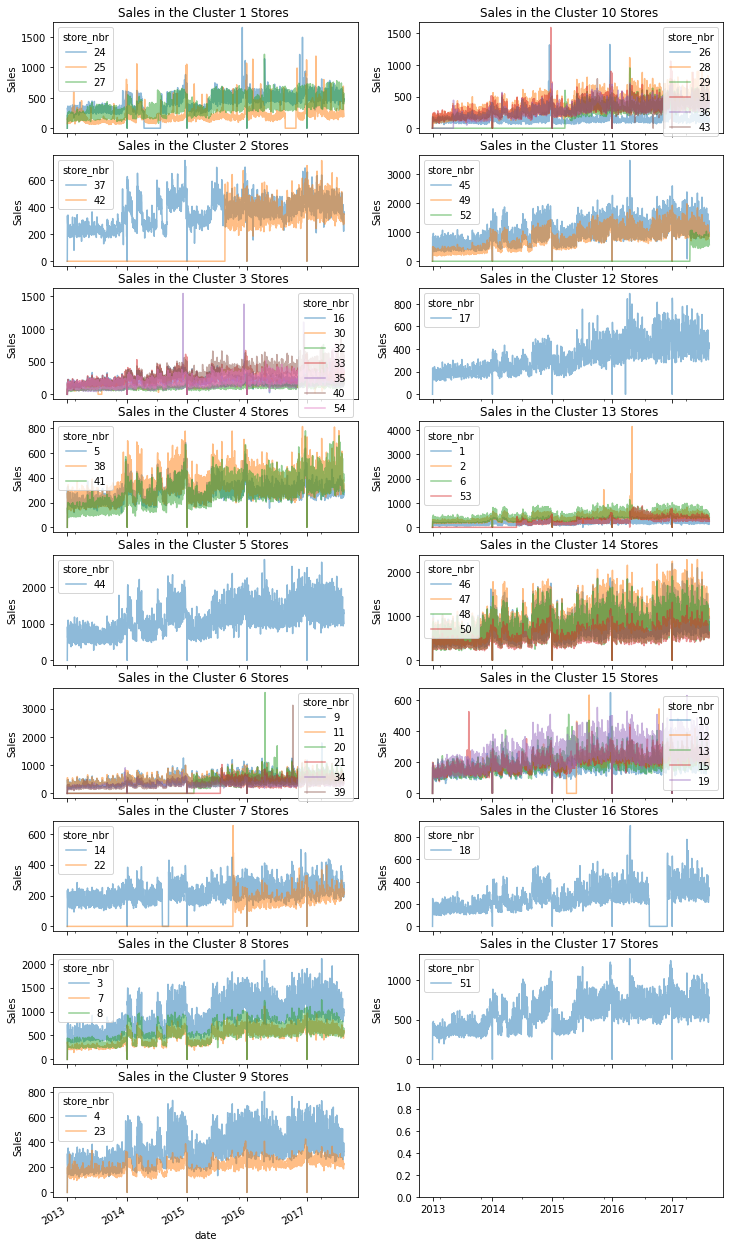

In [508]:
# Stores in the same cluster have similar sales pattern
n_clusters = len(stores['cluster'].unique())
f,ax=plt.subplots(nrows=9,ncols=2,figsize=(12,24),sharex=True)
for i in range(n_clusters):
    j=0
    if i>=9:
        k=1
        j+=i-9
    else:
        k=0
        j+=i
    pd.pivot_table(train.loc[train['store_nbr'].isin(list(stores.iloc[list(stores.groupby('cluster').groups[i+1])]['store_nbr']))],
                   values = 'sales',
                   index='date',
                   columns='store_nbr').plot(ax=ax[j][k],alpha=0.5)
    ax[j][k].set_title('Sales in the Cluster {} Stores '.format(i+1))
    ax[j][k].set_ylabel('Sales')

## Questions:
### Meaning of ‘transaction’?? How to use this feature?

<AxesSubplot:xlabel='date'>

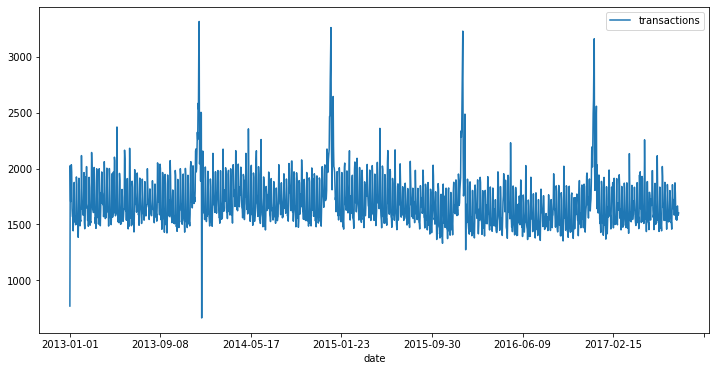

In [432]:
# Transactions have annual cycle.
f,ax=plt.subplots(figsize=(12,6))
transactions.groupby('date').mean().plot(y='transactions',ax=ax)

# Data Clean_Ziyi

In [104]:
# 1. Packages
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# 2. Import Data
## Make sure you are under the folder with all datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
#sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])
# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00         0.00
1   1 2013-01-01          1   BABY CARE   0.00         0.00
2   2 2013-01-01          1      BEAUTY   0.00         0.00
3   3 2013-01-01          1   BEVERAGES   0.00         0.00
4   4 2013-01-01          1       BOOKS   0.00         0.00

In [8]:
# 3. Transactions

transactions.head(10)

temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))
px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )


a = transactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")


a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )


px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")


a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

Spearman Correlation between Total Sales and Transactions: 0.8175


Correlation with Daily Oil Prices
sales          -0.30
transactions    0.04
Name: dcoilwtico_interpolated, dtype: float64 



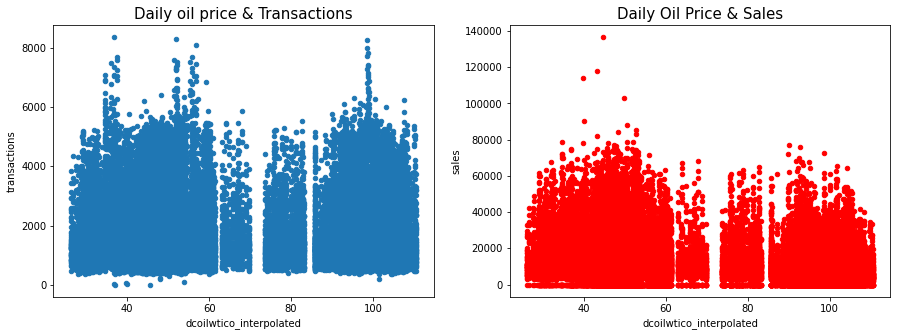

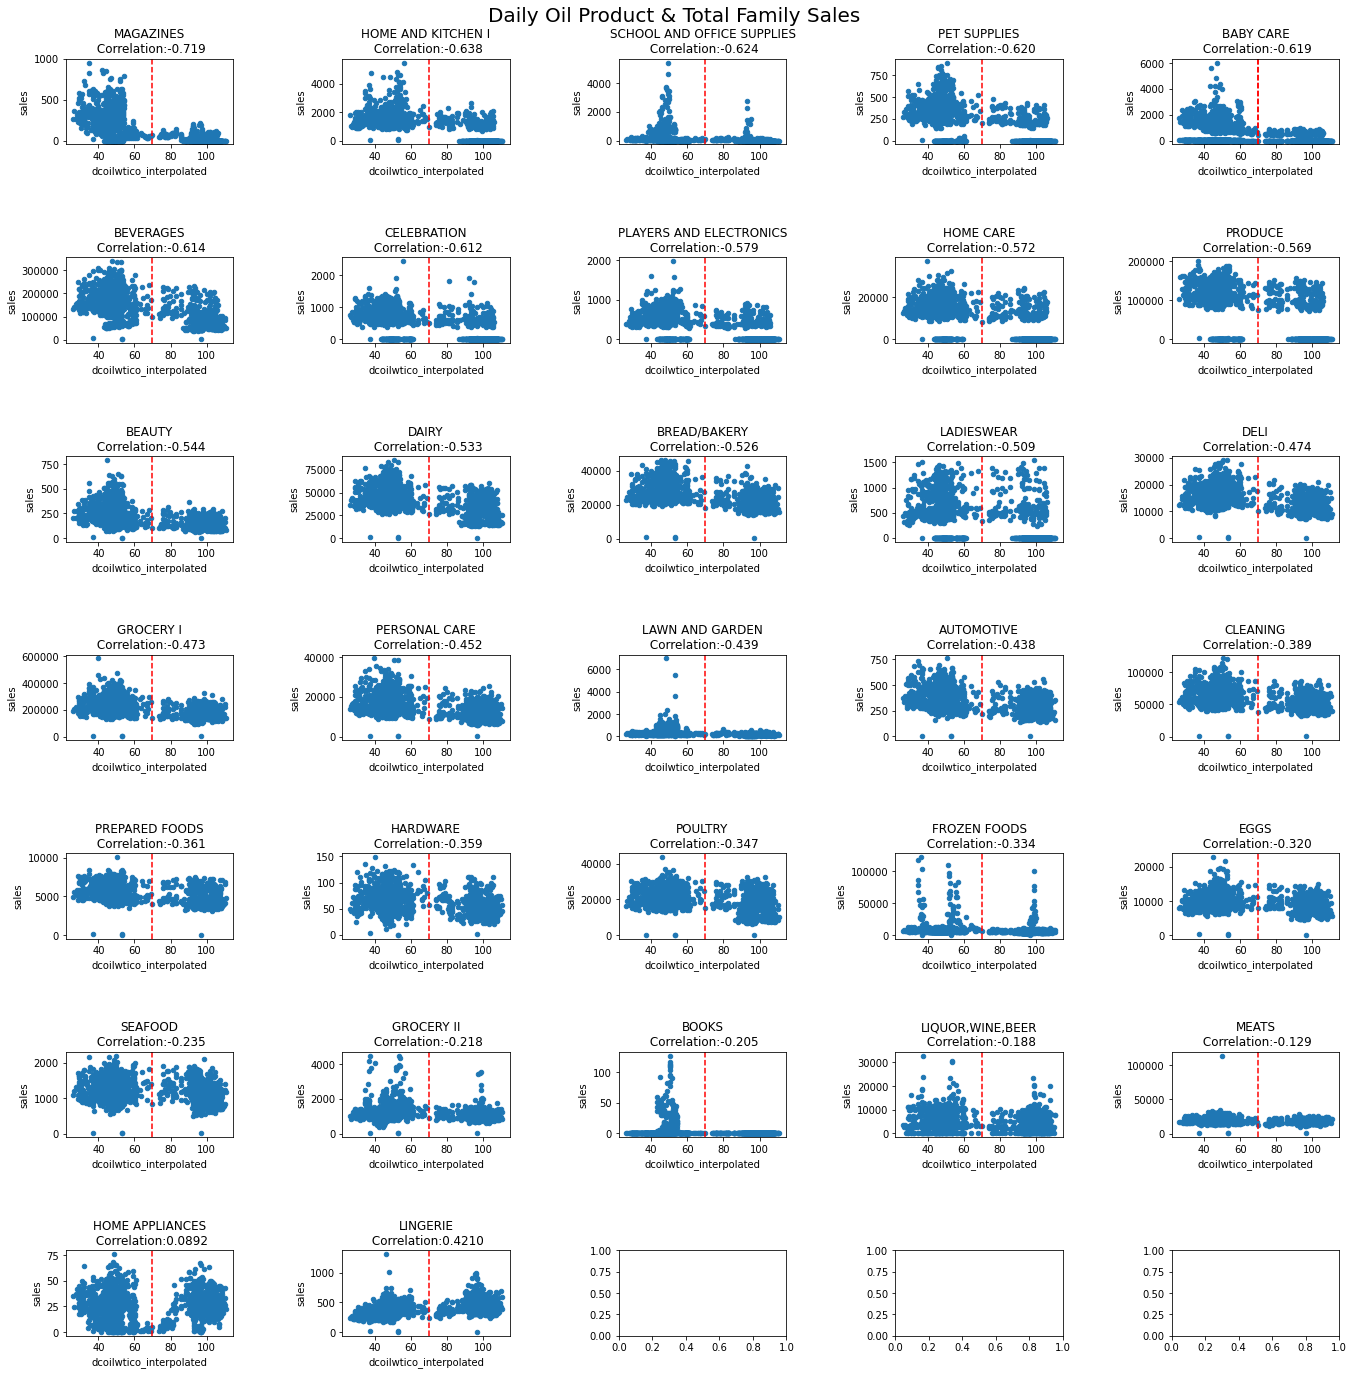

In [9]:
#4. Oil price
# Import 
oil = pd.read_csv("oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

temp = pd.merge(temp, oil, how = "left")
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")


fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);



a = pd.merge(train.groupby(["date", "family"]).sales.sum().reset_index(), oil.drop("dcoilwtico", axis = 1), how = "left")
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

fig, axes = plt.subplots(7, 5, figsize = (20,20))
for i, fam in enumerate(c.family):
    if i < 6:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[0, i-1])
        axes[0, i-1].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    if i >= 6 and i<11:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1, i-6])
        axes[1, i-6].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[1, i-6].axvline(x=70, color='r', linestyle='--')
    if i >= 11 and i<16:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[2, i-11])
        axes[2, i-11].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[2, i-11].axvline(x=70, color='r', linestyle='--')
    if i >= 16 and i<21:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[3, i-16])
        axes[3, i-16].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[3, i-16].axvline(x=70, color='r', linestyle='--')
    if i >= 21 and i<26:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[4, i-21])
        axes[4, i-21].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[4, i-21].axvline(x=70, color='r', linestyle='--')
    if i >= 26 and i < 31:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[5, i-26])
        axes[5, i-26].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[5, i-26].axvline(x=70, color='r', linestyle='--')
    if i >= 31 :
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[6, i-31])
        axes[6, i-31].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[6, i-31].axvline(x=70, color='r', linestyle='--')
        
        
plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize = 20);
plt.show()

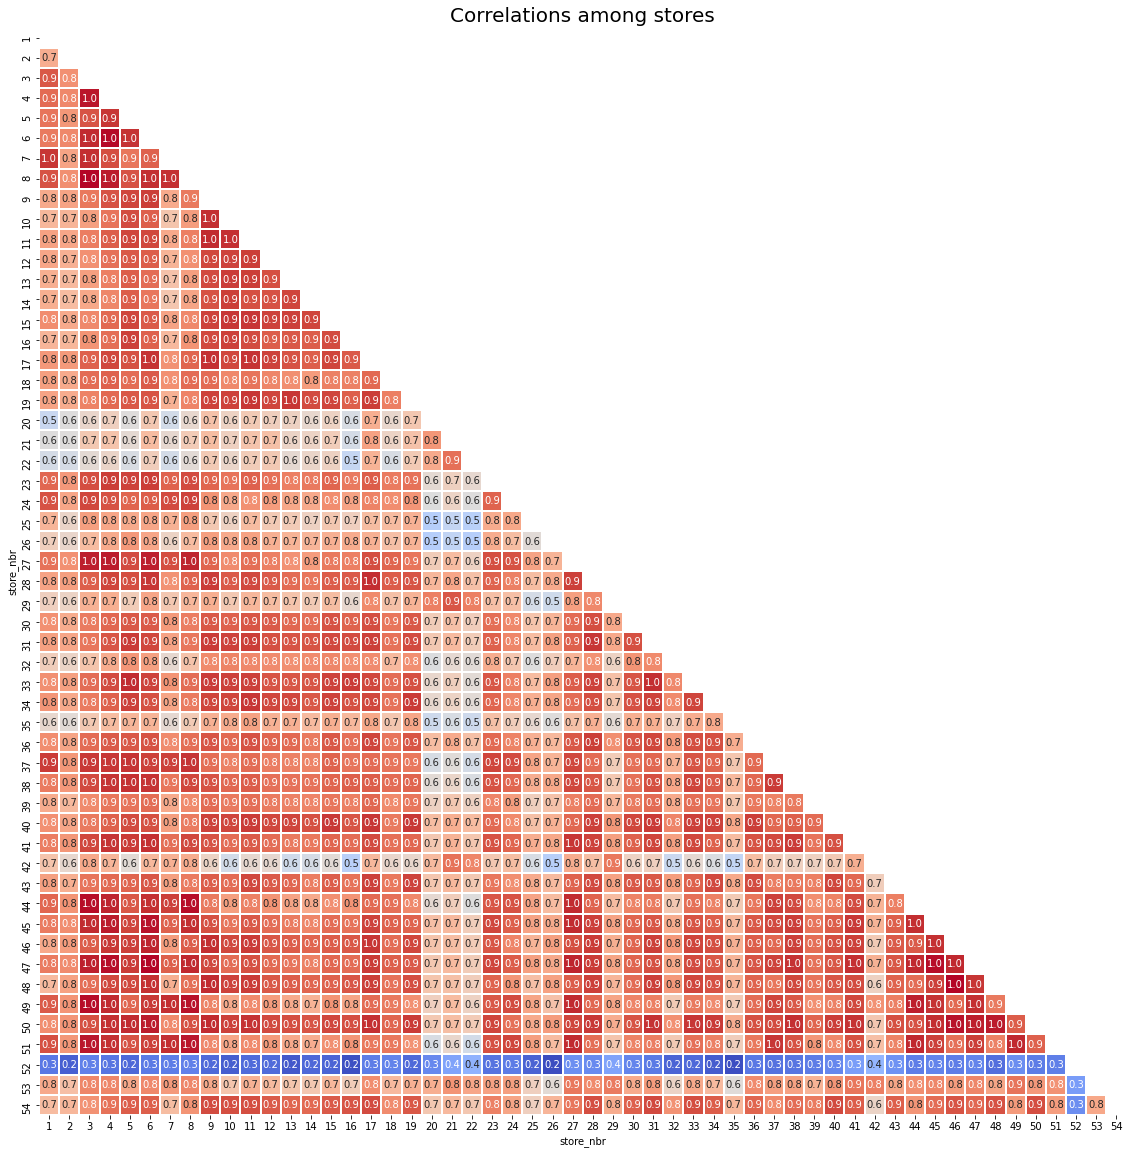

(3000888, 6)
(2780316, 6)
(2780316, 6)
(2698648, 6)
         date  store_nbr           family  sales
0  2017-08-16          1        BABY CARE      0
1  2017-08-17          1        BABY CARE      0
2  2017-08-18          1        BABY CARE      0
3  2017-08-19          1        BABY CARE      0
4  2017-08-20          1        BABY CARE      0
..        ...        ...              ...    ...
11 2017-08-27         54  LAWN AND GARDEN      0
12 2017-08-28         54  LAWN AND GARDEN      0
13 2017-08-29         54  LAWN AND GARDEN      0
14 2017-08-30         54  LAWN AND GARDEN      0
15 2017-08-31         54  LAWN AND GARDEN      0

[848 rows x 4 columns]


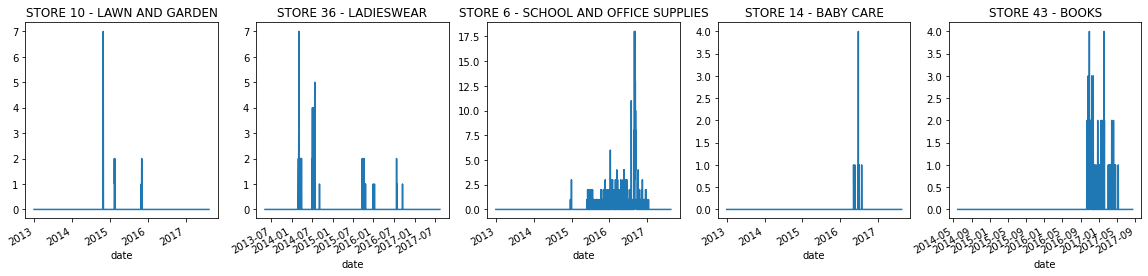

Spearman Correlation between Sales and Onpromotion: 0.5304


In [12]:
#5. Sales
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

print(train.shape)
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
print(train.shape)

c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

print(train.shape)
# Anti Join
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
print(train.shape)

zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )

zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
print(zero_prediction)

c = train.groupby(["family", "store_nbr"]).tail(60).groupby(["family", "store_nbr"]).sales.sum().reset_index()
c[c.sales == 0]



fig, ax = plt.subplots(1,5, figsize = (20,4))
train[(train.store_nbr == 10) & (train.family == "LAWN AND GARDEN")].set_index("date").sales.plot(ax = ax[0], title = "STORE 10 - LAWN AND GARDEN")
train[(train.store_nbr == 36) & (train.family == "LADIESWEAR")].set_index("date").sales.plot(ax = ax[1], title = "STORE 36 - LADIESWEAR")
train[(train.store_nbr == 6) & (train.family == "SCHOOL AND OFFICE SUPPLIES")].set_index("date").sales.plot(ax = ax[2], title = "STORE 6 - SCHOOL AND OFFICE SUPPLIES")
train[(train.store_nbr == 14) & (train.family == "BABY CARE")].set_index("date").sales.plot(ax = ax[3], title = "STORE 14 - BABY CARE")
train[(train.store_nbr == 53) & (train.family == "BOOKS")].set_index("date").sales.plot(ax = ax[4], title = "STORE 43 - BOOKS")
plt.show()





a = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "family", title = "Daily total sales of the family")

a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Which product family preferred more?")


print("Spearman Correlation between Sales and Onpromotion: {:,.4f}".format(train.corr("spearman").sales.loc["onpromotion"]))




d = pd.merge(train, stores)
d["store_nbr"] = d["store_nbr"].astype("int8")
d["year"] = d.date.dt.year
px.line(d.groupby(["city", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "city")



In [14]:
#6. Holidays and Events

holidays = pd.read_csv("holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)

# holidays[holidays.type == "Holiday"]
# holidays[(holidays.type == "Holiday") & (holidays.transferred == True)]

# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


# Split

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()



d = pd.merge(train.append(test), stores)
d["store_nbr"] = d["store_nbr"].astype("int8")


# National Holidays & Events
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

# 
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)




#AB test
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
    # Print Hypothesis
    # print("# A/B Testing Hypothesis")
    # print("H0: A == B")
    # print("H1: A != B", "\n")
    
    return temp
    
# Apply A/B Testing
he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
ab = []
for i in he_cols:
    ab.append(AB_Test(dataframe=d[d.sales.notnull()], group = i, target = "sales"))
ab = pd.concat(ab)
ab

d.groupby(["family","events_Futbol"]).sales.mean()[:60]


family                   events_Futbol
AUTOMOTIVE               0                  6.59
                         1                  6.20
BABY CARE                0                  0.15
                         1                  0.09
BEAUTY                   0                  4.02
                         1                  2.89
BEVERAGES                0               2577.73
                         1               2243.45
BOOKS                    0                  0.15
                         1                  0.00
BREAD/BAKERY             0                500.48
                         1                451.53
CELEBRATION              0                  9.06
                         1                  6.43
CLEANING                 0               1157.94
                         1               1102.08
DAIRY                    0                765.46
                         1                759.26
DELI                     0                286.35
                         1    

In [ ]:
#7. Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
d = create_date_features(d)




# Workday column
d["workday"] = np.where((d.holiday_national_binary == 1) | (d.holiday_local_binary==1) | (d.holiday_regional_binary==1) | (d['day_of_week'].isin([6,7])), 0, 1)
d["workday"] = pd.Series(np.where(d.IsWorkDay.notnull(), 1, d["workday"])).astype("int8")
d.drop("IsWorkDay", axis = 1, inplace = True)

# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
d["wageday"] = pd.Series(np.where((d['is_month_end'] == 1) | (d["day_of_month"] == 15), 1, 0)).astype("int8")

d.head(15)

d.to_csv('train_clean_Ziyi.csv')

# Shuqi Lin -- 6.26

In [105]:
#8. Did Earhquake affect the store sales?
d[(d.month.isin([4,5]))].groupby(["year"]).sales.mean()
Mar_ave=pd.pivot_table(d[(d.month.isin([3]))], index="year", columns="family", values="sales", aggfunc="mean")
AprMay_ave=pd.pivot_table(d[(d.month.isin([4,5]))], index="year", columns="family", values="sales", aggfunc="mean")
Jun_ave=pd.pivot_table(d[(d.month.isin([6]))], index="year", columns="family", values="sales", aggfunc="mean")

Products that affected by earthquake: ['BEVERAGES', 'GROCERY I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'PERSONAL CARE', 'PET SUPPLIES']


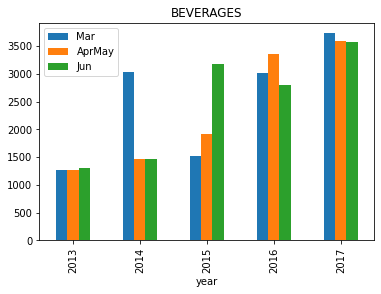

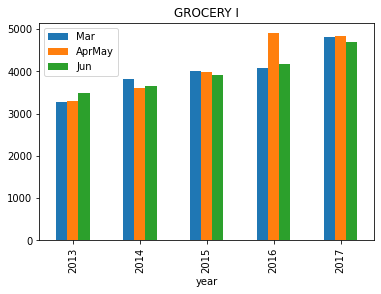

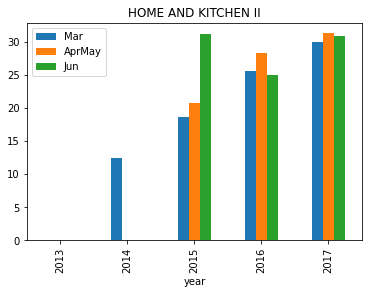

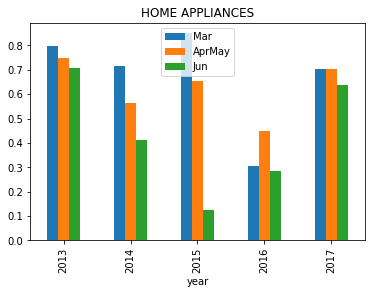

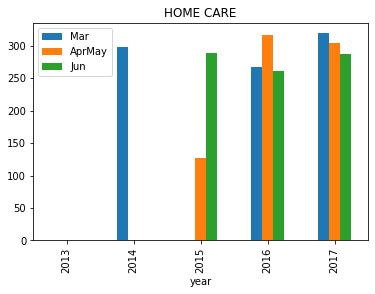

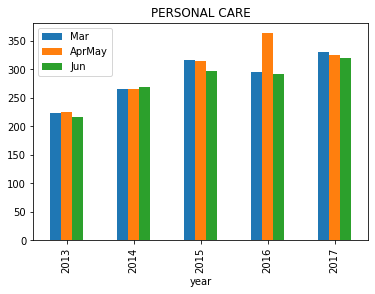

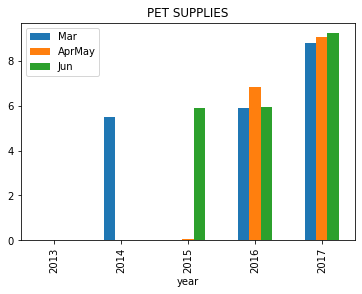

In [106]:
earthquake_families=[]
for i in Mar_ave.columns:
    comp=pd.concat([Mar_ave[i],AprMay_ave[i],Jun_ave[i]],axis=1)
    comp.columns=['Mar','AprMay','Jun']
    increase=pd.Series({'2016':(comp.loc[2016]['AprMay']-comp.loc[2016]['Mar'])/comp.loc[2016]['Mar']*100,
                   '2017':(comp.loc[2017]['AprMay']-comp.loc[2017]['Mar'])/comp.loc[2017]['Mar']*100})
    if (increase['2016']>10)&(increase['2017']<5):
        comp.plot(kind='bar',title=i)
        earthquake_families.append(i)
print('Products that affected by earthquake: '+ str(earthquake_families))